In [1]:
import numpy as np
from numpy import random
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import umap

In [2]:
from prosstt import simulation as sim
from prosstt import tree
from prosstt import sim_utils as sut

In [3]:
random.seed(1992) # truly random

In [4]:
import pyrogue.rogue as prg

/g/arendt/npapadop/repos/condas/ensomatosis/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preparation

Define a simple single bifurcation tree. We will use this as the underlying biological truth, and will utilise it for sanity checks. We won't bother with non-informative genes to keep this simple, may revisit later.

In [5]:
num_brpoints = 8

# sample the parameters randomly:
G = random.randint(100, 1001)
gene_scale = np.exp(sp.stats.norm.rvs(loc=0.7, scale=1, size=G))

alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=G))
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=G)) + 1

num_branches = 2 * num_brpoints + 1
top = tree.Tree.gen_random_topology(num_brpoints)

branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}

t = tree.Tree(topology=top, time=time, num_branches=num_branches, G=G)

Ms = {}
uMs, Ws, H = sim.simulate_lineage(t, a=0.05, intra_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
Ms = {}
for branch in t.branches:
    Ms[branch] = np.exp(uMs[branch]) * gene_scale
t.add_genes(Ms)

/g/arendt/npapadop/repos/condas/ensomatosis/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [6]:
t.modules, t.branch_times()

(6,
 defaultdict(list,
             {0: [0, 49],
              1: [50, 99],
              2: [50, 99],
              3: [100, 149],
              4: [100, 149],
              5: [100, 149],
              6: [100, 149],
              7: [150, 199],
              8: [150, 199],
              9: [150, 199],
              10: [150, 199],
              11: [150, 199],
              12: [150, 199],
              13: [200, 249],
              14: [200, 249],
              15: [250, 299],
              16: [250, 299]}))

Sample the tree at three points to create three populations of cells that should be distinguishable from each other:

In [7]:
X, pseudotime, branches_x, scalings = sim.sample_whole_tree(t, 10, alpha=alpha, beta=beta)
Y, pseudotime, branches_y, scalings = sim.sample_whole_tree(t, 10, alpha=alpha, beta=beta)

In [8]:
def calc_cpm(expr_mat):
    """
    Divide each cell by its library size and multiply with 10^6
    """
    norm = np.sum(expr_mat, axis=1)
    return (expr_mat.T / norm).T * 1e6

def calc_mean(expr_mat):
    """
    Divide each cell by its library size and multiply with the average library size
    """
    norm = np.sum(expr_mat, axis=1)
    return (expr_mat.T / norm * np.mean(norm)).T


def log_umap(expr_mat, pc_comps=10, normalise=None):
    """
    Log-transform the data, calculate PCA and then use components for UMAP.
    """
    if normalise == "cpm":
        normalised = calc_cpm(expr_mat)
    elif normalise == "mean":
        normalised = calc_mean(expr_mat)
    elif normalise is None:
        normalised = expr_mat
    else:
        print("'normalise' argument unacceptable.")
        raise ValueError

    pca = PCA(n_components=10)
    pca.fit(np.log(normalised.T+1))
    reducer = umap.UMAP()
    return reducer.fit_transform(pca.components_.T)

In [9]:
data = np.concatenate((X, Y))

In [10]:
expr = pd.DataFrame(data.T)
labels = np.concatenate((branches_x, branches_y))
samples = np.concatenate((np.repeat(0, X.shape[0]), np.repeat(1, Y.shape[0])))
# # platform = NULL
# # k = NULL
# min_cluster_size = 10 # min.cell.n
# remove_outlier = 2 # remove.outlier.n
# span = 0.5
# r = 1
# filter_low = False # filter
# min_cells = 10 # min.cells
# min_genes = 10 # min.genes
# mt_method = "fdr_bh" # mt.method

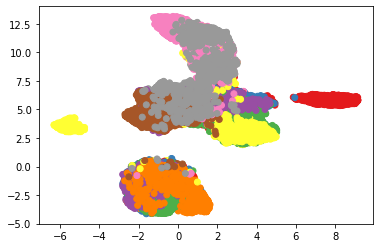

In [11]:
test = log_umap(data)

fig, ax = plt.subplots()
ax.scatter(test[:, 0], test[:, 1], c=labels, cmap="Set1");

In [12]:
prg.rogue(expr, labels, samples, platform="UMI")

[(0, 0, 0.954042627271107),
 (0, 1, 0.9425017368798108),
 (1, 0, 0.994555507963269),
 (1, 1, 0.9886692111580805),
 (2, 0, 0.9938389855561993),
 (2, 1, 1.0),
 (3, 0, 0.9941371996206723),
 (3, 1, 0.9972456731417438),
 (4, 0, 0.987890111541891),
 (4, 1, 0.9969331621027352),
 (5, 0, 1.0),
 (5, 1, 1.0),
 (6, 0, 0.9942344883760541),
 (6, 1, 0.9920106625087195),
 (7, 0, 0.9940523714584935),
 (7, 1, 0.9865163160345743),
 (8, 0, 1.0),
 (8, 1, 0.9942961276382367),
 (9, 0, 0.8970916560355903),
 (9, 1, 0.900592922393064),
 (10, 0, 0.9971276758994352),
 (10, 1, 1.0),
 (11, 0, 1.0),
 (11, 1, 1.0),
 (12, 0, 0.9968361037743682),
 (12, 1, 0.9933102010811218),
 (13, 0, 1.0),
 (13, 1, 0.9942626089328208),
 (14, 0, 0.9932871407986272),
 (14, 1, 0.9909937758911888),
 (15, 0, 0.9958380677703612),
 (15, 1, 0.9918889315296976),
 (16, 0, 0.9762252513941044),
 (16, 1, 0.9729915839566784)]